## Using gmpy2

In [9]:
import os
import math
import gmpy2
import libnum
import time

# Function to compute modular inverse
def mod_inverse(x, n):
    return gmpy2.invert(x, n)

# L function for decryption
def L(x, n):
    return (x - 1) // n

# Function to generate a secure prime
def generate_secure_prime(bit_length):
    while True:
        prime = libnum.generate_prime(bit_length)
        if prime % 2 == 1:  # Ensure it's odd
            return prime

# Paillier key generation using secure prime generation
def generate_keys_code_a(bit_length=512):
    p = generate_secure_prime(bit_length // 2)
    q = generate_secure_prime(bit_length // 2)

    n = p * q  # n = p * q
    n_sq = n * n  # n^2 for the modulus in encryption

    # λ (lambda) = lcm(p-1, q-1)
    lambda_param = (p - 1) * (q - 1) // math.gcd(p - 1, q - 1)

    g = n + 1
    mu = mod_inverse(L(pow(g, lambda_param, n_sq), n), n)

    public_key = (n, g)
    private_key = (lambda_param, mu)

    return public_key, private_key

class EncryptedNumber:
    def __init__(self, ciphertext):
        self.ciphertext = ciphertext

    def __str__(self):
        return f"<EncryptedNumber object at {hex(id(self))}>"

def encrypt(public_key, plaintext):
    n, g = public_key
    n_sq = n * n

    # Ensure randomness by using os.urandom
    while True:
        r = int.from_bytes(os.urandom(n.bit_length() // 8), 'big') % n
        if r != 0:  # Ensure r is not zero
            break

    ciphertext = (pow(g, plaintext, n_sq) * pow(r, n, n_sq)) % n_sq
    return EncryptedNumber(ciphertext)

def decrypt(private_key, public_key, encrypted_number):
    n, g = public_key
    lambda_param, mu = private_key
    n_sq = n * n

    ciphertext = encrypted_number.ciphertext

    x = pow(ciphertext, lambda_param, n_sq)
    plaintext = (L(x, n) * mu) % n
    return plaintext

def homomorphic_add(public_key, c1, c2):
    n, _ = public_key
    n_sq = n * n
    return EncryptedNumber((c1.ciphertext * c2.ciphertext) % n_sq)


## Using Python In-bulit libnum

In [10]:
import math
import libnum
import time

# Function to compute modular inverse
def mod_inverse(x, n):
    return pow(x, -1, n)

# L function for decryption
def L(x, n):
    return (x - 1) // n

# Paillier key generation using libnum for prime generation
def generate_keys_code_b(bit_length=512):
    p = libnum.generate_prime(bit_length // 2)
    q = libnum.generate_prime(bit_length // 2)

    n = p * q  # n = p * q
    n_sq = n * n  # n^2 for the modulus in encryption

    # λ (lambda) = lcm(p-1, q-1)
    lambda_param = (p - 1) * (q - 1) // math.gcd(p - 1, q - 1)

    # g can be any number (usually n+1)
    g = n + 1

    # µ = (L(g^λ mod n^2))^(-1) mod n
    mu = mod_inverse(L(pow(g, lambda_param, n_sq), n), n)

    public_key = (n, g)
    private_key = (lambda_param, mu)

    return public_key, private_key

class EncryptedNumber:
    def __init__(self, ciphertext):
        self.ciphertext = ciphertext

    def __str__(self):
        return f"<EncryptedNumber object at {hex(id(self))}>"

def encrypt(public_key, plaintext):
    n, g = public_key
    n_sq = n * n

    # Choose random r where 1 <= r < n
    r = libnum.randint_bits(n.bit_length() - 1) % n

    ciphertext = (pow(g, plaintext, n_sq) * pow(r, n, n_sq)) % n_sq
    return EncryptedNumber(ciphertext)

def decrypt(private_key, public_key, encrypted_number):
    n, g = public_key
    lambda_param, mu = private_key
    n_sq = n * n

    ciphertext = encrypted_number.ciphertext

    x = pow(ciphertext, lambda_param, n_sq)
    plaintext = (L(x, n) * mu) % n
    return plaintext

def homomorphic_add(public_key, c1, c2):
    n, _ = public_key
    n_sq = n * n
    return EncryptedNumber((c1.ciphertext * c2.ciphertext) % n_sq)


## Plotting Graphs

Testing Code A with 512-bit keys...
Testing Code B with 512-bit keys...
Testing Code A with 1024-bit keys...
Testing Code B with 1024-bit keys...
Testing Code A with 2048-bit keys...
Testing Code B with 2048-bit keys...
Testing Code A with 4096-bit keys...
Testing Code B with 4096-bit keys...

Timing Results (in seconds):

Key Size   | Code A KeyGen  | Code A Enc   | Code A Add   | Code A Dec   || Code B KeyGen  | Code B Enc   | Code B Add   | Code B Dec  
--------------------------------------------------------------------------------------------------------------------------------------------
512        | 0.023201       | 0.004322     | 0.000015     | 0.004325     || 0.025493       | 0.003731     | 0.000008     | 0.003490    
1024       | 0.116412       | 0.023001     | 0.000023     | 0.023753     || 0.151788       | 0.022980     | 0.000023     | 0.023160    
2048       | 1.066705       | 0.162031     | 0.000075     | 0.164124     || 0.899524       | 0.163011     | 0.000086     | 0.1

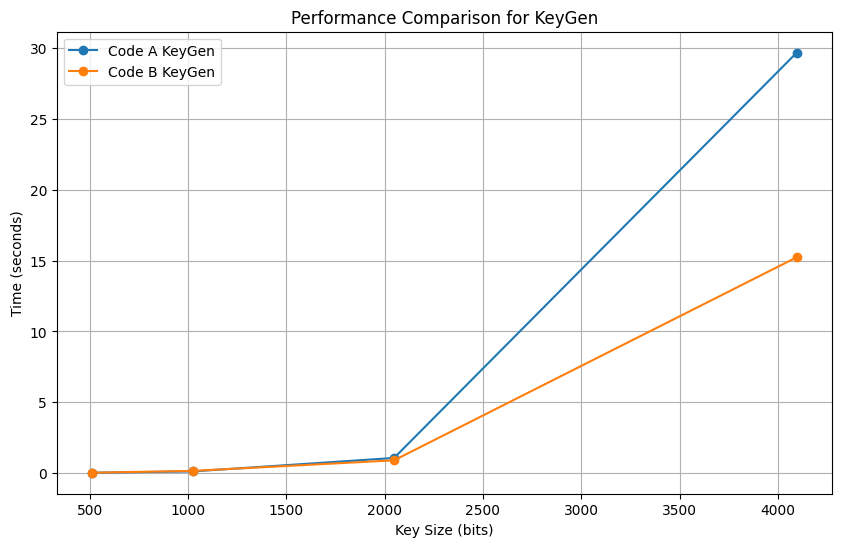

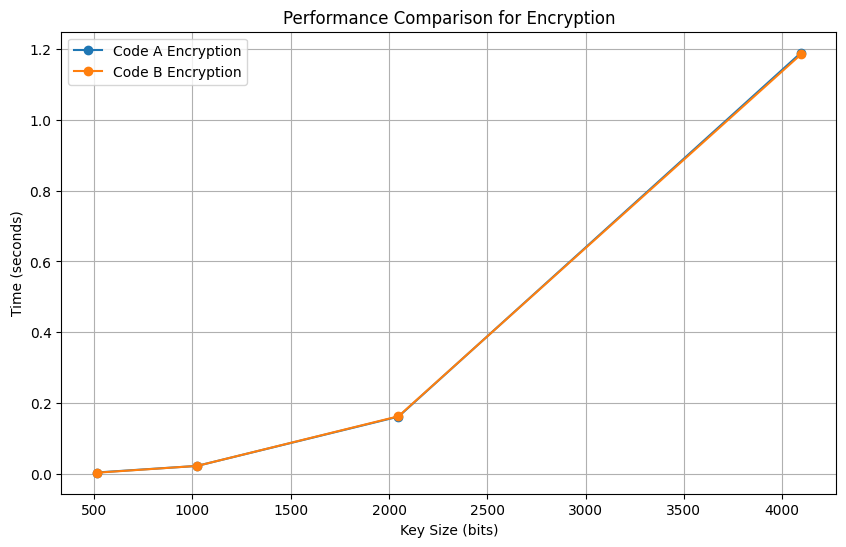

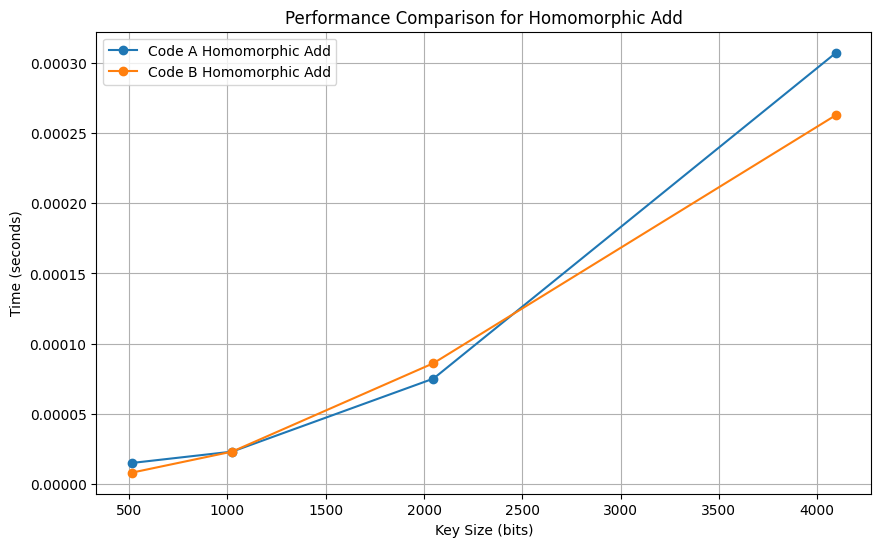

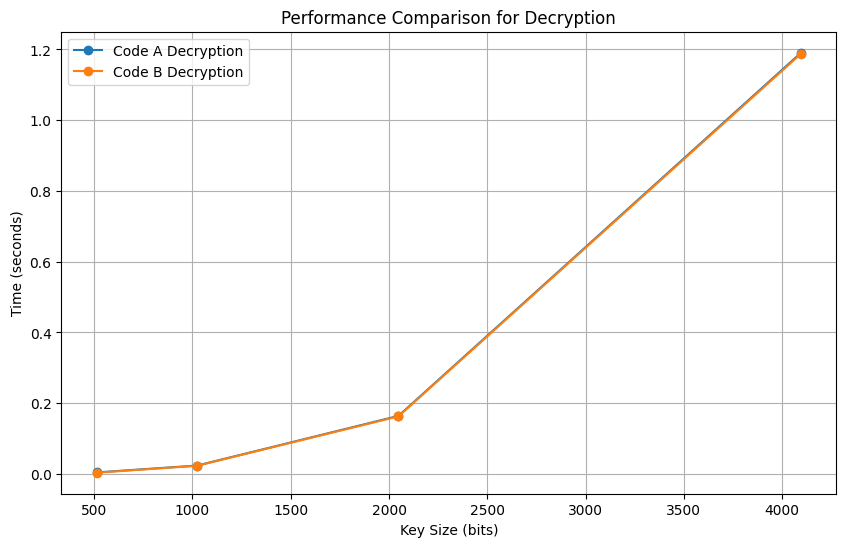

In [12]:
import time
import matplotlib.pyplot as plt

# Function to test performance of both codes for various key sizes
def test_performance_for_key_sizes(key_sizes):
    results_code_a = {}
    results_code_b = {}

    for bit_size in key_sizes:
        # Testing Code A
        print(f"Testing Code A with {bit_size}-bit keys...")
        start_time = time.time()
        public_key_a, private_key_a = generate_keys_code_a(bit_size)
        keygen_time_a = time.time() - start_time

        start_time = time.time()
        c1_a = encrypt(public_key_a, 42)
        encryption_time_a = time.time() - start_time

        start_time = time.time()
        c3_a = homomorphic_add(public_key_a, c1_a, c1_a)
        add_time_a = time.time() - start_time

        start_time = time.time()
        decrypt(private_key_a, public_key_a, c3_a)
        decryption_time_a = time.time() - start_time

        # Store results for Code A
        results_code_a[bit_size] = (keygen_time_a, encryption_time_a, add_time_a, decryption_time_a)

        # Testing Code B
        print(f"Testing Code B with {bit_size}-bit keys...")
        start_time = time.time()
        public_key_b, private_key_b = generate_keys_code_b(bit_size)
        keygen_time_b = time.time() - start_time

        start_time = time.time()
        c1_b = encrypt(public_key_b, 42)
        encryption_time_b = time.time() - start_time

        start_time = time.time()
        c3_b = homomorphic_add(public_key_b, c1_b, c1_b)
        add_time_b = time.time() - start_time

        start_time = time.time()
        decrypt(private_key_b, public_key_b, c3_b)
        decryption_time_b = time.time() - start_time

        # Store results for Code B
        results_code_b[bit_size] = (keygen_time_b, encryption_time_b, add_time_b, decryption_time_b)

    return results_code_a, results_code_b

# Function to print the results
def print_results(results_code_a, results_code_b):
    print("\nTiming Results (in seconds):\n")
    print(f"{'Key Size':<10} | {'Code A KeyGen':<14} | {'Code A Enc':<12} | {'Code A Add':<12} | {'Code A Dec':<12} || "
          f"{'Code B KeyGen':<14} | {'Code B Enc':<12} | {'Code B Add':<12} | {'Code B Dec':<12}")
    print("-" * 140)

    for key_size in results_code_a:
        a_res = results_code_a[key_size]
        b_res = results_code_b[key_size]
        print(f"{key_size:<10} | {a_res[0]:<14.6f} | {a_res[1]:<12.6f} | {a_res[2]:<12.6f} | {a_res[3]:<12.6f} || "
              f"{b_res[0]:<14.6f} | {b_res[1]:<12.6f} | {b_res[2]:<12.6f} | {b_res[3]:<12.6f}")

# Plotting function to compare the results
def plot_results(key_sizes, results_code_a, results_code_b):
    labels = ['KeyGen', 'Encryption', 'Homomorphic Add', 'Decryption']
    for i, label in enumerate(labels):
        times_a = [results_code_a[size][i] for size in key_sizes]
        times_b = [results_code_b[size][i] for size in key_sizes]
        
        plt.figure(figsize=(10, 6))
        plt.plot(key_sizes, times_a, label=f'Code A {label}', marker='o')
        plt.plot(key_sizes, times_b, label=f'Code B {label}', marker='o')
        plt.xlabel('Key Size (bits)')
        plt.ylabel('Time (seconds)')
        plt.title(f'Performance Comparison for {label}')
        plt.legend()
        plt.grid(True)
        plt.show()

# Test and plot results for key sizes 512, 1024, 2048, 4096
key_sizes = [512, 1024, 2048, 4096]
results_code_a, results_code_b = test_performance_for_key_sizes(key_sizes)
print_results(results_code_a, results_code_b)
plot_results(key_sizes, results_code_a, results_code_b)


In [7]:
pip install memory-profiler


Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
import math
import gmpy2
import libnum
import cProfile
import memory_profiler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Code A Implementation
def mod_inverse_a(x, n):
    return gmpy2.invert(x, n)

def L_a(x, n):
    return (x - 1) // n

def generate_secure_prime_a(bit_length):
    while True:
        prime = libnum.generate_prime(bit_length)
        if prime % 2 == 1:
            return prime

def generate_keys_a(bit_length=512):
    p = generate_secure_prime_a(bit_length // 2)
    q = generate_secure_prime_a(bit_length // 2)
    n = p * q
    n_sq = n * n
    lambda_param = (p - 1) * (q - 1) // math.gcd(p - 1, q - 1)
    g = n + 1
    mu = mod_inverse_a(L_a(pow(g, lambda_param, n_sq), n), n)
    public_key = (n, g)
    private_key = (lambda_param, mu)
    return public_key, private_key

class EncryptedNumberA:
    def __init__(self, ciphertext):
        self.ciphertext = ciphertext

def encrypt_a(public_key, plaintext):
    n, g = public_key
    n_sq = n * n
    while True:
        r = int.from_bytes(os.urandom(n.bit_length() // 8), 'big') % n
        if r != 0:
            break
    ciphertext = (pow(g, plaintext, n_sq) * pow(r, n, n_sq)) % n_sq
    return EncryptedNumberA(ciphertext)

def decrypt_a(private_key, public_key, encrypted_number):
    n, g = public_key
    lambda_param, mu = private_key
    n_sq = n * n
    ciphertext = encrypted_number.ciphertext
    x = pow(ciphertext, lambda_param, n_sq)
    plaintext = (L_a(x, n) * mu) % n
    return plaintext

# Code B Implementation
def mod_inverse_b(x, n):
    return pow(x, -1, n)

def L_b(x, n):
    return (x - 1) // n

def generate_keys_b(bit_length=512):
    p = libnum.generate_prime(bit_length // 2)
    q = libnum.generate_prime(bit_length // 2)
    n = p * q
    n_sq = n * n
    lambda_param = (p - 1) * (q - 1) // math.gcd(p - 1, q - 1)
    g = n + 1
    mu = mod_inverse_b(L_b(pow(g, lambda_param, n_sq), n), n)
    public_key = (n, g)
    private_key = (lambda_param, mu)
    return public_key, private_key

class EncryptedNumberB:
    def __init__(self, ciphertext):
        self.ciphertext = ciphertext

def encrypt_b(public_key, plaintext):
    n, g = public_key
    n_sq = n * n
    r = libnum.randint_bits(n.bit_length() - 1) % n
    ciphertext = (pow(g, plaintext, n_sq) * pow(r, n, n_sq)) % n_sq
    return EncryptedNumberB(ciphertext)

def decrypt_b(private_key, public_key, encrypted_number):
    n, g = public_key
    lambda_param, mu = private_key
    n_sq = n * n
    ciphertext = encrypted_number.ciphertext
    x = pow(ciphertext, lambda_param, n_sq)
    plaintext = (L_b(x, n) * mu) % n
    return plaintext

# Function to run and profile Code A
def run_code_a():
    public_key, private_key = generate_keys_a(bit_length=512)
    m1 = 42
    m2 = 23
    c1 = encrypt_a(public_key, m1)
    c2 = encrypt_a(public_key, m2)
    c3 = decrypt_a(private_key, public_key, c1)
    c4 = decrypt_a(private_key, public_key, c2)

# Function to run and profile Code B
def run_code_b():
    public_key, private_key = generate_keys_b(bit_length=512)
    m1 = 42
    m2 = 23
    c1 = encrypt_b(public_key, m1)
    c2 = encrypt_b(public_key, m2)
    c3 = decrypt_b(private_key, public_key, c1)
    c4 = decrypt_b(private_key, public_key, c2)

# Profile both codes
if __name__ == "__main__":
    print("Profiling Code A:")
    mem_a_start = memory_profiler.memory_usage()
    cProfile.run('run_code_a()')
    mem_a_end = memory_profiler.memory_usage()
    
    print("\nProfiling Code B:")
    mem_b_start = memory_profiler.memory_usage()
    cProfile.run('run_code_b()')
    mem_b_end = memory_profiler.memory_usage()
    
    # Print memory usage results
    print(f"\nMemory Usage for Code A: {mem_a_end[-1] - mem_a_start[-1]} MB")
    print(f"Memory Usage for Code B: {mem_b_end[-1] - mem_b_start[-1]} MB")


Profiling Code A:
         2407 function calls in 0.046 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.046    0.046 407009594.py:100(run_code_a)
        1    0.000    0.000    0.003    0.003 407009594.py:13(mod_inverse_a)
        3    0.000    0.000    0.000    0.000 407009594.py:16(L_a)
        2    0.000    0.000    0.027    0.014 407009594.py:19(generate_secure_prime_a)
        1    0.000    0.000    0.032    0.032 407009594.py:25(generate_keys_a)
        2    0.000    0.000    0.000    0.000 407009594.py:38(__init__)
        2    0.000    0.000    0.006    0.003 407009594.py:41(encrypt_a)
        2    0.001    0.001    0.007    0.003 407009594.py:51(decrypt_a)
        1    0.000    0.000    0.046    0.046 <string>:1(<module>)
       24    0.000    0.000    0.000    0.000 common.py:112(extract_prime_power)
      160    0.000    0.000    0.000    0.000 common.py:17(randint_bits)
      232